In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy; import math
import pdb
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
!pip3 install GPUtil
import GPUtil
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm

In [0]:
class Smoother():
    def __init__(self, beta=0.95):
        self.beta, self.n, self.mov_avg = beta, 0, 0
        self.vals = []

    def add_value(self, val):
        self.n += 1
        self.mov_avg = self.beta * self.mov_avg + (1-self.beta)*val
        self.vals.append(self.mov_avg/(1-self.beta**self.n))

    def process(self,array):
        for item in array:
            self.add_value(item)
        return self.vals

    def reset(self):
        self.n, self.mov_avg, self.vals = 0,0,[]


class Stepper():
    def __init__(self, opt):
        self.it = 0
        self.opt = opt
        self.nits = 1

    def step(self):
        self.opt.step()

    def zero_grad(self):
        self.opt.zero_grad()
    
    @staticmethod
    def cosine_anneal(pct, max_val, min_val):
        return min_val + (max_val - min_val) / 2 *(1+np.cos(np.pi * pct))
    
    @staticmethod
    def exp_anneal(pct, start, stop):
        return start * (stop/start)**pct
    
    @staticmethod
    def linear_anneal(pct, start, stop):
        return (1-pct)*start + pct*stop


class OneCycle(Stepper):
    def __init__(self, opt, nits=1, max_lr=1e-3, momentums=[0.85,0.95], div=25, pct_start=0.3):
        super(OneCycle, self).__init__(opt)
        self.nits = nits
        self.max_lr = max_lr
        self.momentums = momentums
        self.div = div
        self.pct_start = pct_start
        self.phase = 0
        self.switch = int(pct_start * nits)
    
    def step(self):
        self.opt.step()
        self.it += 1
        if self.phase == 0: 
            pct = self.it / (self.nits * self.pct_start)
            new_lr = self.cosine_anneal(pct, self.max_lr/self.div, self.max_lr)
            new_mom = self.cosine_anneal(pct, self.momentums[1], self.momentums[0])
            for group in self.opt.param_groups:
                group['lr'] = new_lr
                if 'betas' in group.keys():
                    group['betas'] = (new_mom, group['betas'][1])
                else:
                    group['momentum'] = new_mom
            if self.it > self.switch:
                self.phase += 1
                self.it = 0
        
        else: 
            pct = self.it / (self.nits * (1-self.pct_start))
            new_lr = self.cosine_anneal(pct, self.max_lr, self.max_lr * 1e-4)
            new_mom = self.cosine_anneal(pct, self.momentums[0], self.momentums[1])
            for group in self.opt.param_groups:
                group['lr'] = new_lr
                if 'betas' in group.keys():
                    group['betas'] = (new_mom, group['betas'][1])
                else:
                    group['momentum'] = new_mom


class LearningRateFinder(Stepper):
    def __init__(self, opt, nits=1, min_lr=1e-6, max_lr=1e1):
        super(LearningRateFinder, self).__init__(opt)
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.pct_start = 0
        self.nits = nits
        for group in self.opt.param_groups:
            group['lr'] = min_lr
    
    def step(self):
        self.opt.step()
        self.it+=1 
        new_lr = self.exp_anneal(self.it / self.nits, self.min_lr, self.max_lr)
        for group in self.opt.param_groups:
            group['lr'] = new_lr
    
    @staticmethod
    def plot_lr_find(tr_history, clip=True):                                
        fig, ax = plt.subplots()
        if clip:
            end = int(0.90 * len(tr_history))
            tr_history = tr_history.iloc[:end]
        ax.plot(tr_history.learning_rate, tr_history.tr_loss)
        ax.set_xscale('log')
        ax.legend()
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')            
            
    def lr_find(self, model, tr_dl, criterion):
        tr_losses = []
        lrs = []
        iterator = iter(tr_dl)
        self.it = 0 
        while self.it <= self.nits:
            inputs, labels = next(iterator)
            self.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            self.step()
            tr_losses.append(loss.item())
            lrs.append(self.opt.param_groups[-1]['lr'])
        smoother = Smoother()
        tr_losses = smoother.process(tr_losses)
        tr_history = pd.DataFrame({'tr_loss':tr_losses, 'learning_rate':lrs})
        self.plot_lr_find(tr_history)
        return None 
    
    
class UnfreezeAnneal(Stepper):
    def __init__(self, opt, nits=1, max_lr=1e-3, pct_start = 0.3):
        super(UnfreezeAnneal, self).__init__(opt)
        self.nits = nits
        self.max_lr = max_lr
        self.pct_start = pct_start
        self.phase = 0
        self.switch = int(pct_start * nits)
    
    def step(self):
        self.opt.step()
        self.it+=1 
        if self.phase==0:
            pct = self.it / (self.nits * self.pct_start)
            new_lr = self.linear_anneal(pct, 0, self.max_lr * 1e-5)
            for group in self.opt.param_groups:
                group['lr'] = new_lr
            if self.it > self.switch:
                self.phase += 1
                self.it = 0
        else:
            pct = self.it / (self.nits * (1-self.pct_start))
            new_lr = self.cosine_anneal(pct, self.max_lr * 1e-5, self.max_lr)
            for group in self.opt.param_groups:
                group['lr'] = new_lr  


def fit_regressor(model, stepper, criterion, dataloaders, num_epochs=1):
    start = time.time()
    dataset_sizes = {'train':len(dataloaders['train'].dataset), 'val':len(dataloaders['val'].dataset)}
    tr_losses = []
    lrs = []
    epoch_losses = {'train': [], 'val': []}
    epoch_accs = {'train': [], 'val': []}
    stepper.nits = num_epochs * len(dataloaders['train'].dataset) / (dataloaders['train'].batch_size)
    stepper.switch = int(stepper.pct_start * stepper.nits)
    stepper.it = 0
    stepper.phase = 0 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)
        GPUs = GPUtil.getGPUs()
        for i, gpu in enumerate(GPUs):
          print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))
    
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_losses = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                stepper.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    stepper.step()
                    tr_losses.append(loss.item())
                    lrs.append(stepper.opt.param_groups[-1]['lr'])

                running_losses += loss.item() * inputs[0].size(0)

            epoch_loss = running_losses / dataset_sizes[phase]
            epoch_losses[phase].append(epoch_loss)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

    elapsed_time = time.time() - start
    elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))    
    print(elapsed_time)
    return None
 

In [0]:
stv_df = pd.read_csv('./sales_train_validation.csv')


df_for_predictions = stv_df.drop(columns=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
df_for_predictions = df_for_predictions[[f'd_{i}' for i in range(1241,1914)]]
# for i in range(1914,1914 + 28):
#     df_for_predictions[f'd_{i}'] = 0
df_for_predictions.columns = [i for i in range(673)]
df_for_predictions['target'] = 0


df_for_training = stv_df.drop(columns=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
df_for_training = df_for_training[[f'd_{i}' for i in range(1241,1914)]]
df_for_training.columns = [i for i in range(673)]
df_for_training['target'] = 0


##### ONLY TOP N STRINGS
# N = 1000
# df_for_predictions = df_for_predictions.iloc[:N]
# df_for_training = df_for_training.iloc[:N]
#####


ts = pd.melt(df_for_predictions.reset_index(), id_vars=['index','target'],
             var_name='time').rename(columns={'index':'id'})
ts = ts.groupby(['id','time','target']).value.mean().reset_index()

id          HOBBIES_1_032_CA_1_validation
item_id                     HOBBIES_1_032
dept_id                         HOBBIES_1
cat_id                            HOBBIES
store_id                             CA_1
                        ...              
d_1909                                  0
d_1910                                  0
d_1911                                  2
d_1912                                  4
d_1913                                  4
Name: 31, Length: 1919, dtype: object

In [0]:
class AttentionalModel(nn.Module):
    def __init__(self, encoder, decoder, emb):
        super(AttentionalModel,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.emb = emb
        
    def forward(self, input):
        'Send the input as (src, tgt)'
        src, tgt = input
        return self.decoder(self.emb(tgt), self.encoder(self.emb(src)))
    
    
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)
  

class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory):
        for layer in self.layers:
            x = layer(x, memory)
        return self.norm(x)
    
    
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

    
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))


class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
        return self.sublayer[1](x, self.feed_forward)

class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, m):
        "Follow Figure 1 (right) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m))
        return self.sublayer[2](x, self.feed_forward)
    
    
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
    
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1, decoder=False, cuda=True):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.sub_mask = True if decoder else False
        self.cuda = cuda
        
    def forward(self, query, key, value):
        "Implements Figure 2"
        if self.sub_mask:
            # Same mask applied to all h heads.
            mask = subsequent_mask(query.size(1)).unsqueeze(1)
            mask = mask.cuda() if query.is_cuda else mask
        else: 
            mask = None
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
    
    
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)
    

def make_regressor(in_features=1, n_out=1, N=3, d_model=64, d_ff=128, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, decoder=False)
    dec_attn = MultiHeadedAttention(h, d_model, decoder=True)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    encoder = Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N)
    decoder = Decoder(DecoderLayer(d_model, c(dec_attn), c(attn), c(ff), dropout), N)
    embs = nn.Sequential(nn.Linear(in_features, d_model), c(position))
    model = nn.Sequential(AttentionalModel(encoder, decoder, embs), nn.Linear(d_model, n_out))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model


class RegressionDataset(Dataset):
    def __init__(self, df, h, cuda=True):
        self.x = torch.Tensor(df[df.columns[:-1]].values)
        self.h = h
        self.cuda = cuda
        
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        src = self.x[idx, :self.h].unsqueeze(1)
        tgt = self.x[idx, self.h:-1].unsqueeze(1)
        src = src.cuda() if self.cuda else src
        tgt = tgt.cuda() if self.cuda else tgt
        y = self.x[idx, self.h+1:].unsqueeze(1)
        y = y.cuda() if self.cuda else y
        x = (src, tgt)
        return x, y

In [0]:
!nvidia-smi

Sun Apr  5 21:23:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
h = int(0.9 * df_for_training.shape[1])
print(h)

606


In [0]:
tr_obs = int(0.7 * df_for_training.shape[0])
tr_df = df_for_training.iloc[:tr_obs]
val_df = df_for_training.iloc[tr_obs:]

tr_ds = RegressionDataset(tr_df, h=h)
val_ds = RegressionDataset(val_df, h=h)

BATCH_SIZE = 16
tr_dl = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)
dls = {'train': tr_dl, 'val':val_dl}

model = make_regressor(d_model=64, d_ff=128, N=6).cuda()
crit = nn.MSELoss()
opt = torch.optim.Adam(model.parameters())

# lrf = LearningRateFinder(opt, nits=100, min_lr=1e-5, max_lr=1e-1)
# lrf.lr_find(model, tr_dl, crit)

max_lr = 1e-3
stepper = OneCycle(opt, max_lr=max_lr)

In [0]:
epochs_num = 6

fit_regressor(model, stepper, crit, dls, epochs_num)

Epoch 1/6
----------
GPU 0 ... Mem Free: 7056MB / 7611MB | Utilization   7%



train Loss: 7.6934



val Loss: 7.3619
Epoch 2/6
----------
GPU 0 ... Mem Free: 2160MB / 7611MB | Utilization  72%



train Loss: 5.5897



val Loss: 5.9261
Epoch 3/6
----------
GPU 0 ... Mem Free: 2160MB / 7611MB | Utilization  72%



train Loss: 4.7870



val Loss: 5.6253
Epoch 4/6
----------
GPU 0 ... Mem Free: 2160MB / 7611MB | Utilization  72%



train Loss: 4.4279



val Loss: 5.2789
Epoch 5/6
----------
GPU 0 ... Mem Free: 2160MB / 7611MB | Utilization  72%



train Loss: 4.2143



val Loss: 4.9708
Epoch 6/6
----------
GPU 0 ... Mem Free: 2160MB / 7611MB | Utilization  72%



train Loss: 4.1217



val Loss: 4.9876
00:50:00


In [0]:
class RegressionDataset(Dataset):
    def __init__(self, df, h, cuda=True):
        self.x = torch.Tensor(df[df.columns[:-1]].values)
        self.h = h
        self.cuda = cuda
        
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        src = self.x[idx, :self.h].unsqueeze(1)
        tgt = self.x[idx, self.h:-1].unsqueeze(1)
        src = src.cuda() if self.cuda else src
        tgt = tgt.cuda() if self.cuda else tgt
        y = self.x[idx, self.h+1:].unsqueeze(1)
        y = y.cuda() if self.cuda else y
        x = (src, tgt)
        return x, y

In [0]:
def fetch_predictions(model, df, ts, h, output=False):
    data = RegressionDataset(df, h=h, cuda=True)
    date_range = [k for k in range(h+1,df.shape[1]-1)]
    dl = DataLoader(data, batch_size=16, shuffle=False)
    pieces = []
    model.cuda()
    model.eval()
    for x,y in tqdm(dl):
        pieces.append(model(x).cpu().detach().numpy())
    preds = pd.DataFrame(np.concatenate(pieces).squeeze())
    preds.index = df.index
    preds = preds.transpose()
    preds['time'] = date_range
    pts = pd.melt(preds, id_vars='time', var_name = 'id', value_name = 'predicted_value')
    pts.id = pts.id.astype('int')
    pts = pd.merge(ts, pts, left_on=['time','id'], right_on=['time', 'id'], how='left').fillna(0)
    return pts


def graph_predictions(pts, size=5):
    ids = np.random.choice(np.arange(pts.id.nunique()), size=size)
    for k in ids:
        piece = pts[pts.id == pts.id.unique()[k]]
        piece.index = piece.time
        fig,ax = plt.subplots()
        piece.value.plot.line()
        piece.predicted_value.plot.line()
        ax.legend()
    return None

In [0]:
# h = 673
h = 400
pts = fetch_predictions(model, df_for_predictions, ts, h)

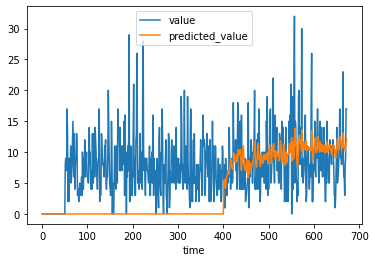

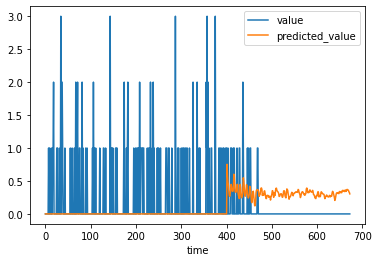

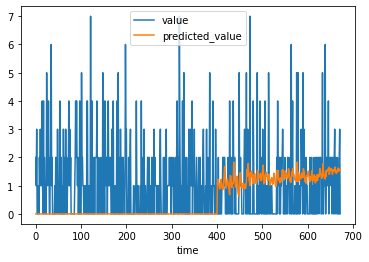

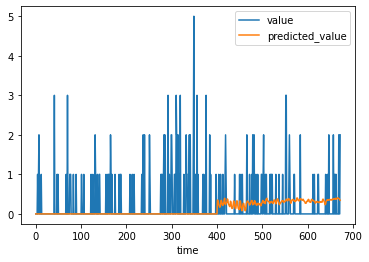

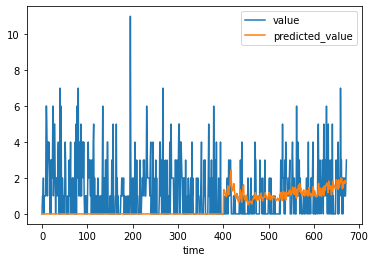

In [0]:
graph_predictions(pts, 5)

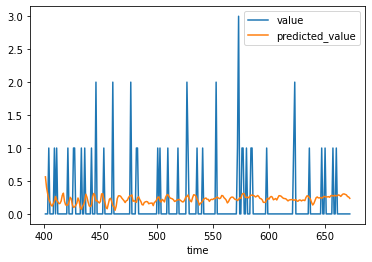

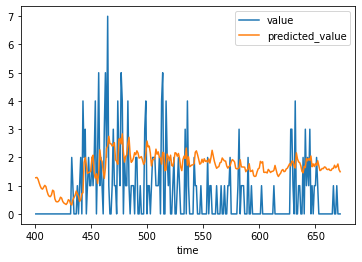

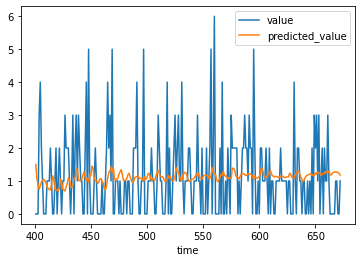

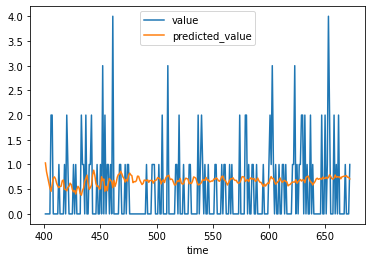

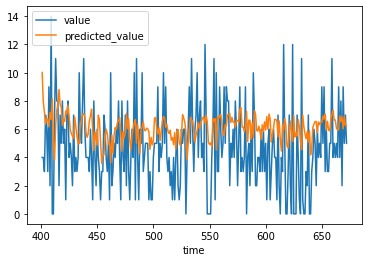

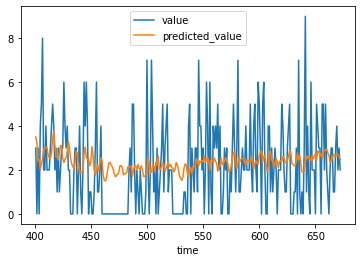

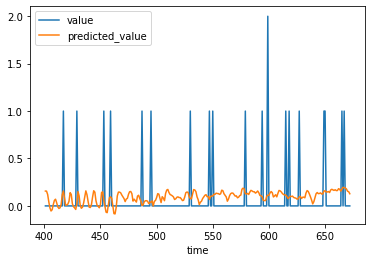

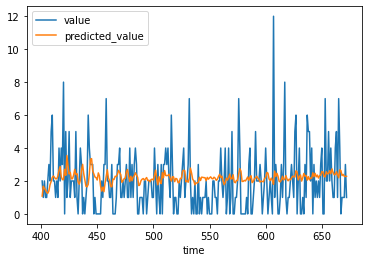

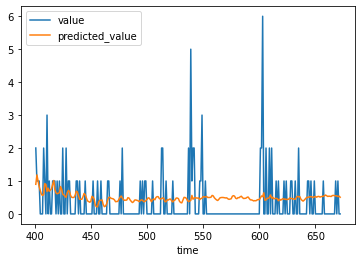

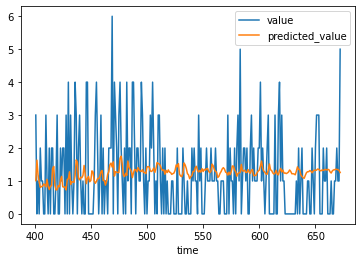

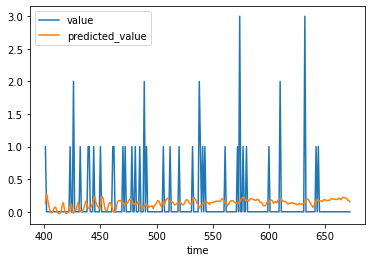

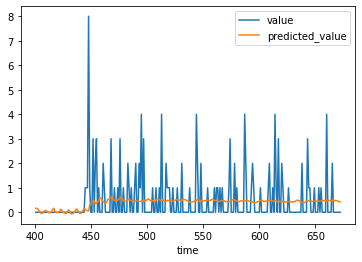

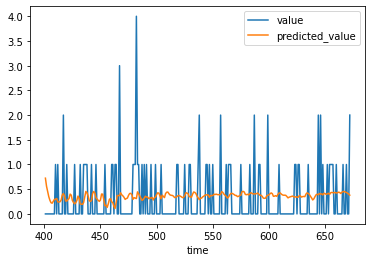

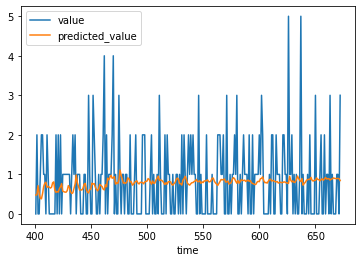

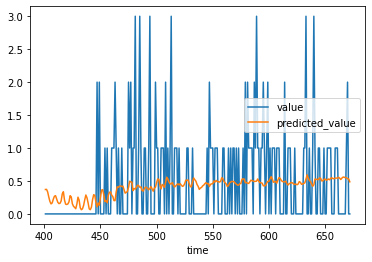

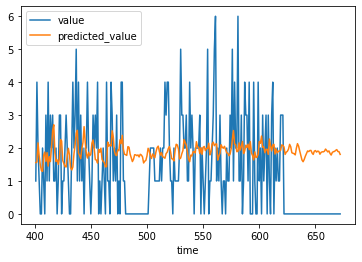

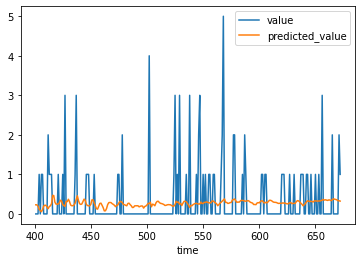

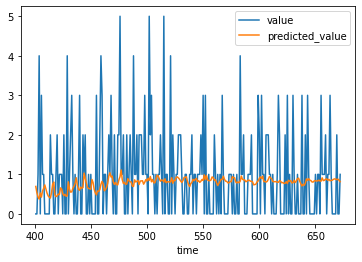

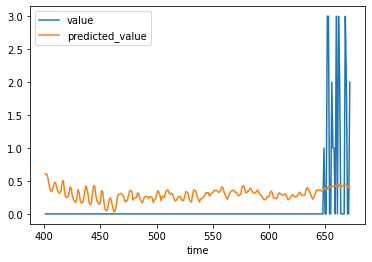

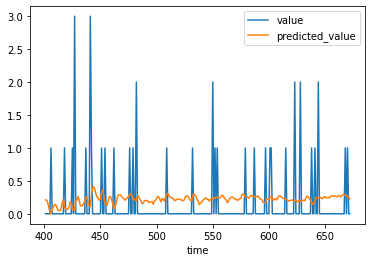

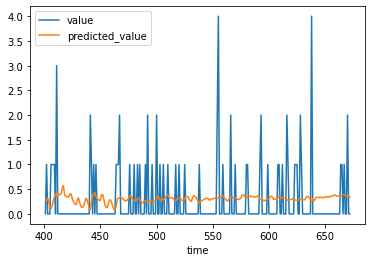

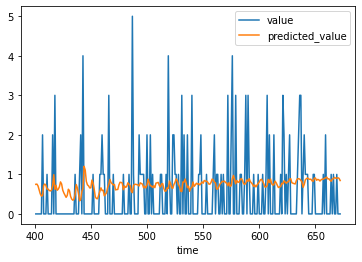

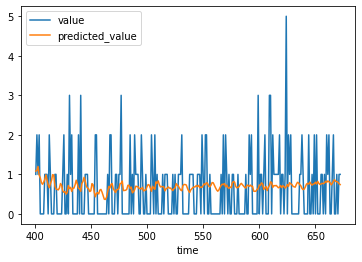

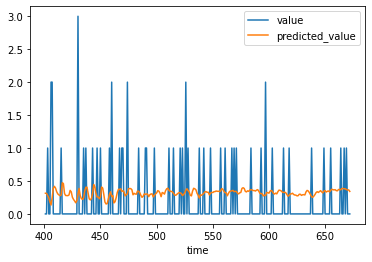

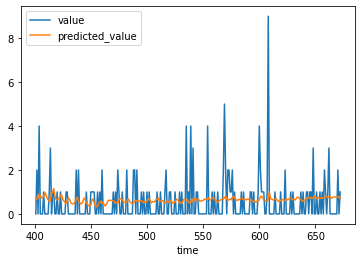

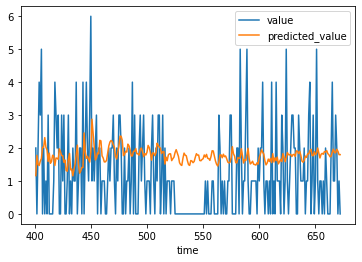

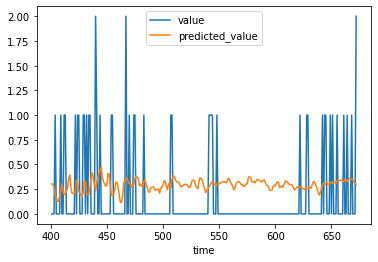

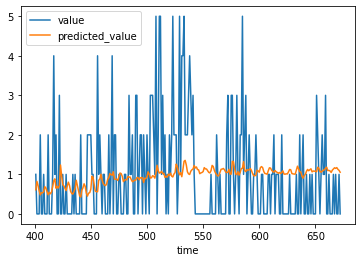

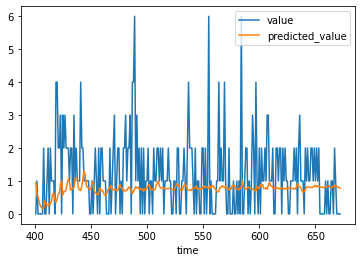

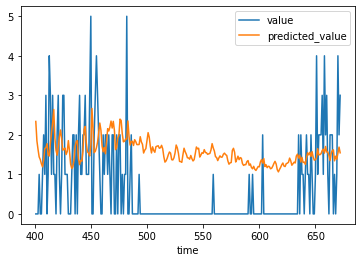

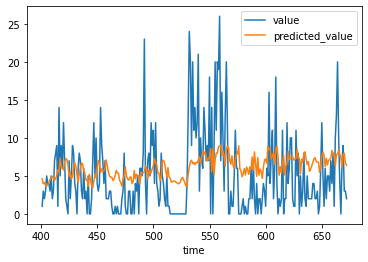

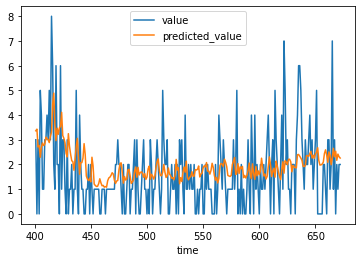

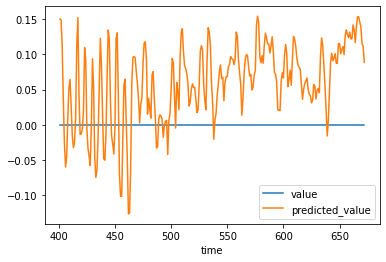

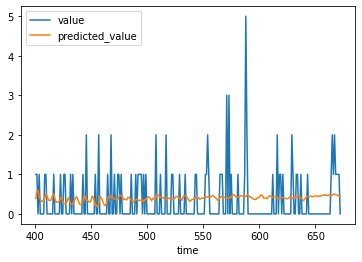

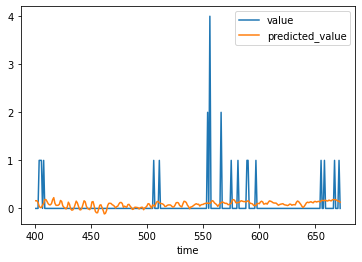

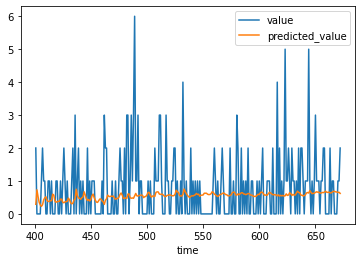

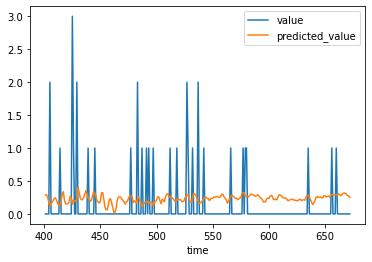

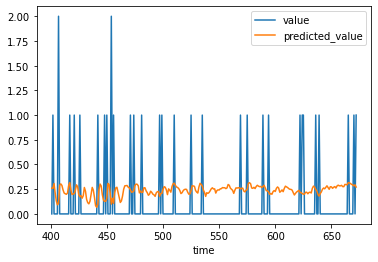

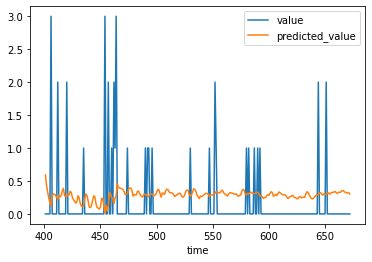

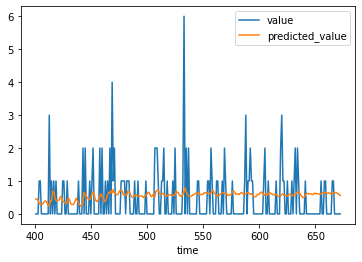

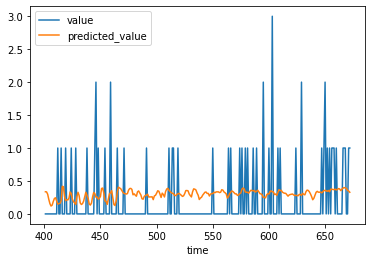

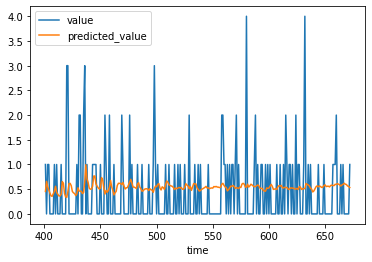

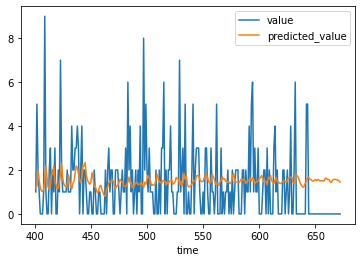

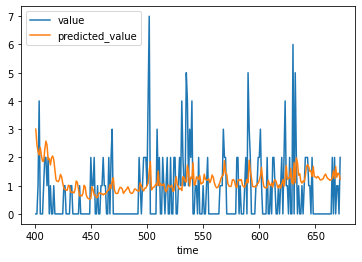

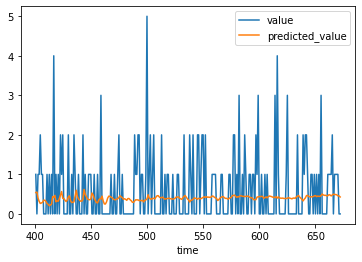

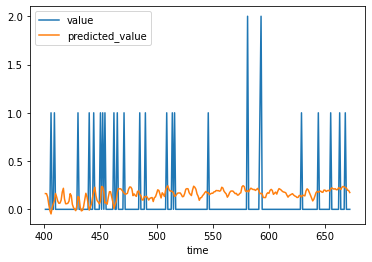

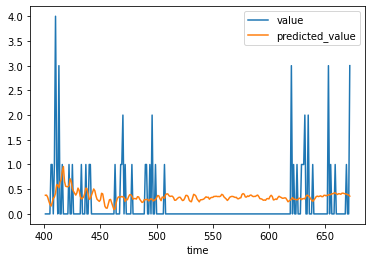

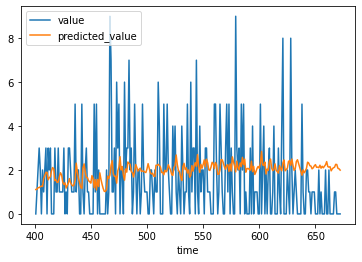

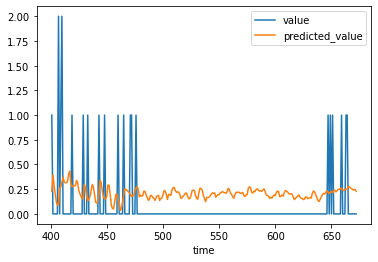

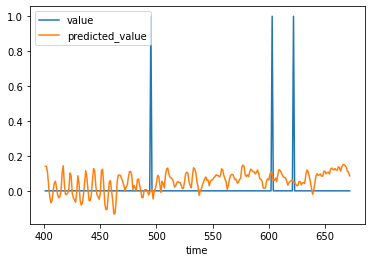

In [0]:
graph_predictions(pts[pts.time > 400], 50)

In [0]:

pts_short = pts[pts['time'] >= 673]
for i in tqdm(range(df_for_predictions.shape[0])):
    predictions = pts_short[pts_short['id'] == i].predicted_value.values
    object_id = stv_df['id'].iloc[i]
    submission.iloc[i] = [object_id] + list(predictions)
    
submission.to_csv('transformer_predictions.csv', index=False)

In [0]:
from google.colab import files
files.download('transformer_predictions.csv')

In [0]:
stv_df.iloc[45]

id          HOBBIES_1_046_CA_1_validation
item_id                     HOBBIES_1_046
dept_id                         HOBBIES_1
cat_id                            HOBBIES
store_id                             CA_1
                        ...              
d_1909                                  0
d_1910                                  0
d_1911                                  1
d_1912                                  1
d_1913                                  1
Name: 45, Length: 1919, dtype: object